<a href="https://colab.research.google.com/github/mt508/machine-learning-/blob/main/housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [2]:
housing_url="https://raw.githubusercontent.com/ageron/data/main/housing/housing.csv"

In [3]:
read_data=pd.read_csv(housing_url)

In [4]:
read_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


here i got some observation
1.   missing value in total_bedroom
2.   ocean_proximity is in text need to convert in number one hot encoding orlabel text method






In [5]:
read_data['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [6]:
read_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

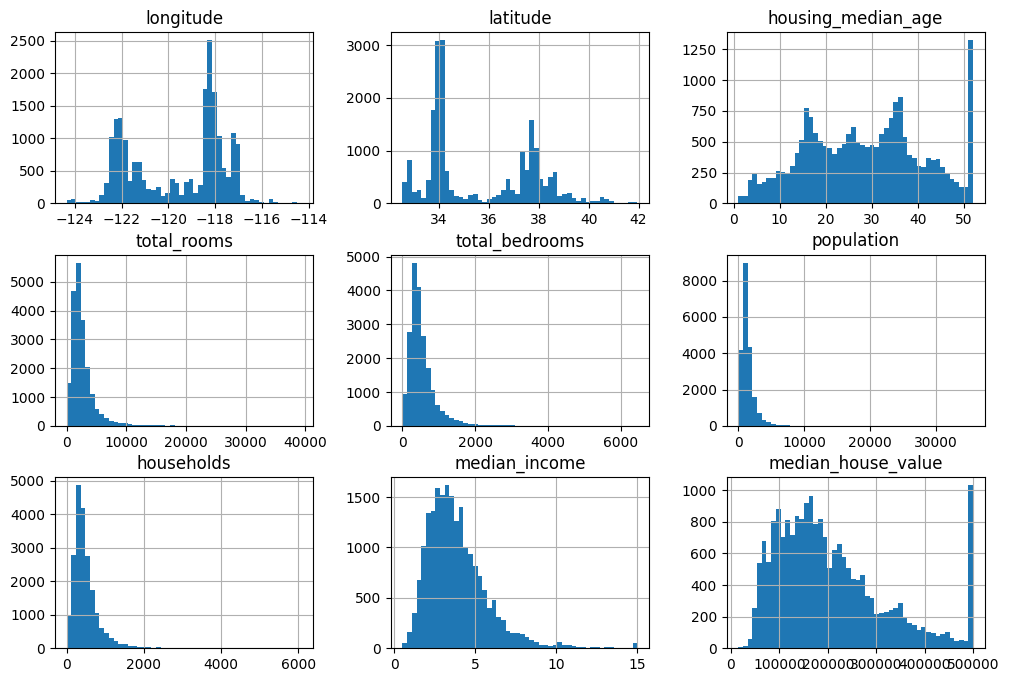

In [7]:
read_data.hist(bins=50, figsize=(12, 8))

notes by visualizing data:-


1.   median income:-its scaled normalize means 15 means 150000 dollar and also capped also
2.   total_room , total_bedrooms, population are skewed to right we can apply log transformation



*   note :- here taget label is capped that cant be done





As we understand our data structures now it's trun to create training and testing data that should be 80 % and 20 % from main data set to avoid **data snooping bias **.



In [8]:
def suffle_and_split(data,test_ratio):
  shuffle_indices=np.random.permutation(len(data)) # array of shuffle indicies of data length.
  test_set_size=int(len(data) *test_ratio)
  test_indices=shuffle_indices[:test_set_size]
  train_indices= shuffle_indices[test_set_size:]
  return data.iloc[train_indices] ,  data.iloc[test_indices] # fetch rows with these indices


what we did here


*   shuffle indices
*   find length of test set and training set
*   get indices of length from shuffle indices
*   get rows from data of that indices



In [9]:
train_set , test_set= suffle_and_split(read_data,0.2)




here we getting an issue over long period of time test set will repeat itself and modal will know all dataset in a period of time .
hence the optimize solution is hash comutation/ id conpuatation
give id to all row if id is 20% of max id of dataset can be elligible for test set even if we update our dataset by add new column it wont effect our test set .


In [10]:
from zlib import crc32

In [11]:
def is_id_in_test_set(indentifier,test_ratio):
  return crc32(np.int64(indentifier)) < test_ratio * 2**32


def split_data_with_id(data,test_ratio,id_column):
  ids=data[id_column]
  in_test_set=ids.apply(lambda id_: is_id_in_test_set(id_,test_ratio))
  return data.loc[~in_test_set],data.loc[in_test_set] #.iloc[] ---> For slicing by position (row 0, 1, 2…),.loc[]--->	For slicing by label or using Boolean masks

In [12]:
housing_with_id=read_data.reset_index()
train_set,test_set=split_data_with_id(housing_with_id,0.2,"index")


* it might have drawback, we can only append row not remove it
* solution use latitude + longitude for hash number because its more stable.






In [13]:
housing_with_id["id"]= read_data['longitude']*1000+read_data['latitude'] # multi with 1000 to reduce duplicacy / redundancy.

train_set,test_set=split_data_with_id(housing_with_id,0.2,"id")

* stratified sampling method use in median income

In [14]:
housing_with_id['income_cat']=pd.cut(read_data['median_income'],bins=[0,1.5,3.0,4.5,6,np.inf],labels=[1,2,3,4,5])


Text(0, 0.5, 'no of district')

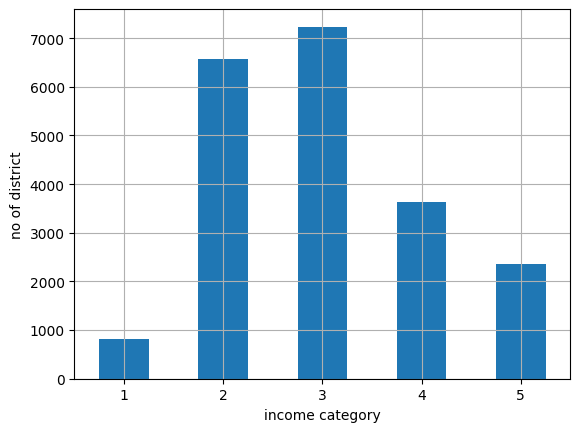

In [15]:
housing_with_id['income_cat'].value_counts().sort_index().plot.bar(rot=0,grid=True)
plt.xlabel("income category")
plt.ylabel("no of district")

our goal is now to preserve categorization in both test and traning dataset.

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
splitter= StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)

strat_splits=[]
for train_index, test_index in splitter.split(housing_with_id,housing_with_id['income_cat']) :
      strat_train_set_n=housing_with_id.iloc[train_index]
      strat_test_set_n=housing_with_id.iloc[test_index]
      strat_splits.append([strat_train_set_n ,strat_test_set_n])


we only wants 1st sample

In [18]:
strat_train_set,strat_test_set=strat_splits[0]


In [19]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)



/tmp/ipython-input-19-766400289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
/tmp/ipython-input-19-766400289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [20]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

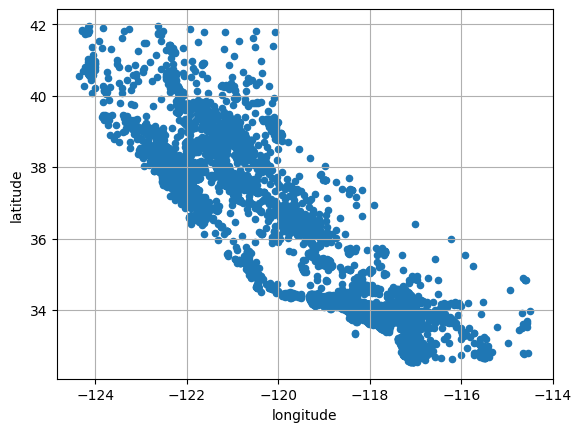

In [21]:
housing.plot(kind="scatter",x="longitude",y="latitude",grid=True)

alpha use for each dot opacity  to understand the density of the points .

<Axes: xlabel='longitude', ylabel='latitude'>

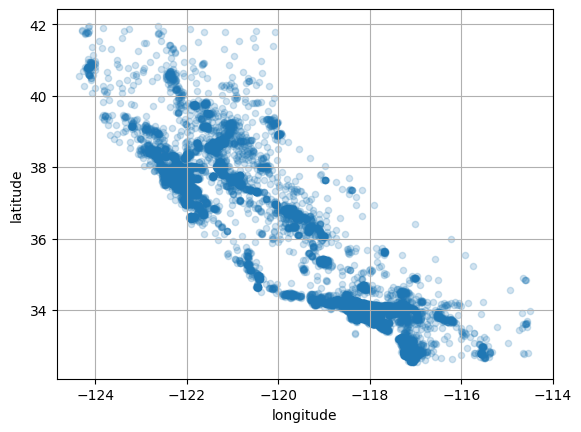

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)





*   show population
*   show median income
in one graph only



<Axes: xlabel='longitude', ylabel='latitude'>

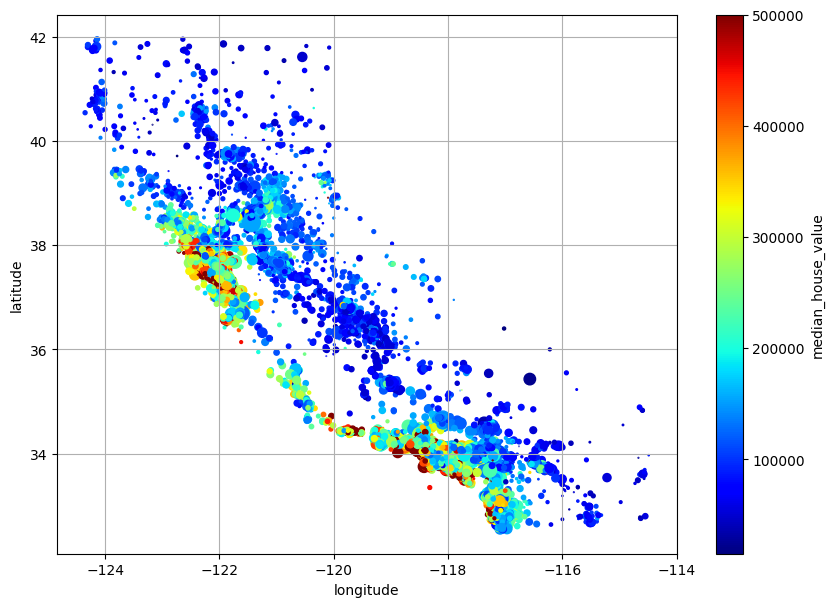

In [23]:
housing.plot(kind="scatter", x= "longitude",y="latitude",grid=True, s=housing["population"]/100,c="median_house_value",cmap="jet",colorbar=True,legend=True,
    sharex=False,
    figsize=(10, 7))

In [24]:
corr_matrix = housing.select_dtypes(include=[float, int]).corr()
print(corr_matrix)


                       index  longitude  latitude  housing_median_age  \
index               1.000000  -0.002214  0.011732           -0.008999   
longitude          -0.002214   1.000000 -0.924213           -0.102937   
latitude            0.011732  -0.924213  1.000000            0.005692   
housing_median_age -0.008999  -0.102937  0.005692            1.000000   
total_rooms         0.002337   0.044558 -0.036753           -0.361710   
total_bedrooms     -0.000112   0.068210 -0.066391           -0.317978   
population          0.003230   0.104236 -0.115677           -0.301906   
households          0.002439   0.054261 -0.071604           -0.300075   
median_income      -0.001128  -0.016542 -0.078137           -0.127043   
median_house_value -0.008913  -0.050859 -0.139584            0.102175   
id                 -0.002204   1.000000 -0.924057           -0.103032   

                    total_rooms  total_bedrooms  population  households  \
index                  0.002337       -0.000112 

In [25]:
corr_with_price = corr_matrix["median_house_value"].sort_values(ascending=False)
print(corr_with_price)


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
index                -0.008913
population           -0.020153
longitude            -0.050859
id                   -0.051058
latitude             -0.139584
Name: median_house_value, dtype: float64


next step isvisualise our matrix

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

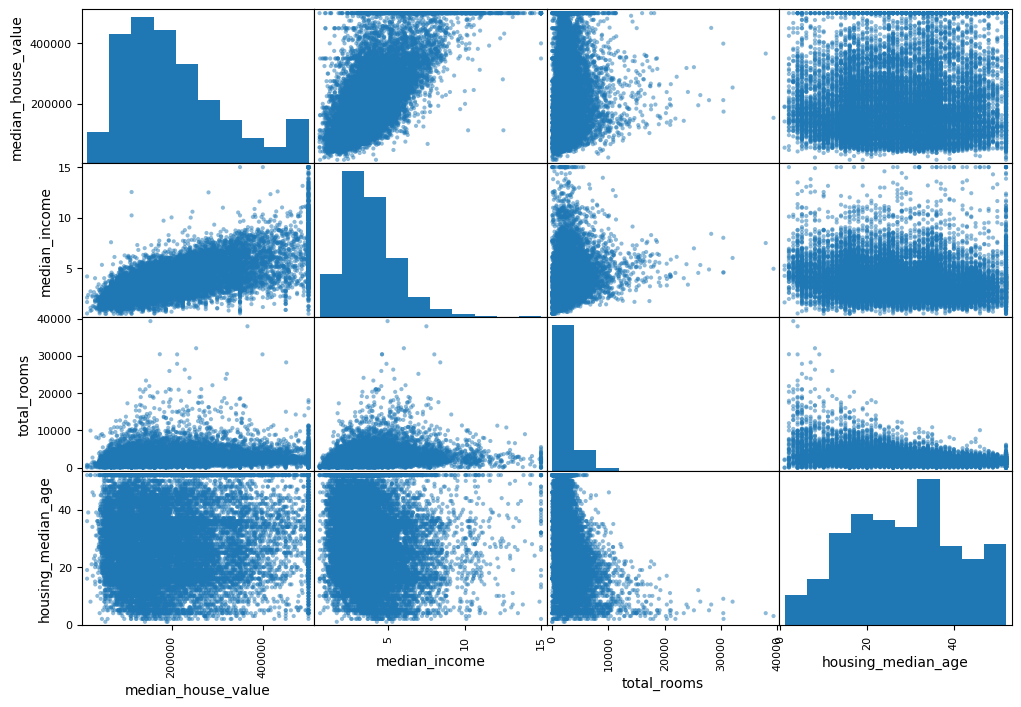

In [26]:

from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))



here clear visible among all "median_income" and "median_house_value " shows + ve correlation


*   flattening at top due to capping or less data in high income




<Axes: xlabel='median_income', ylabel='median_house_value'>

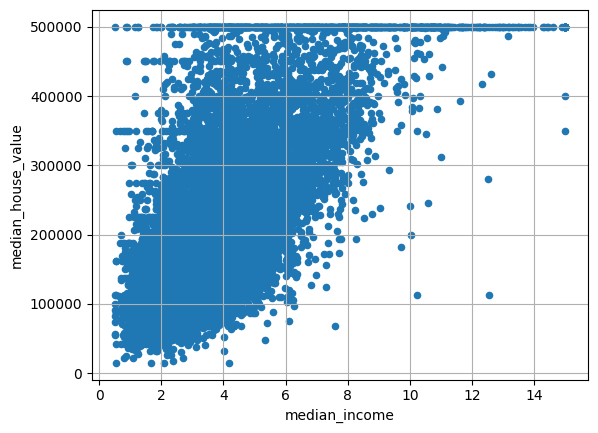

In [27]:
housing.plot(kind="scatter", x='median_income',y='median_house_value', grid=True)

In [28]:
housing["rooms_per_house"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [29]:
corr_matrix = housing.select_dtypes(include=[float, int]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


,median_house_value
median_house_value,1.000000
median_income,0.688380
rooms_per_house,0.143663
total_rooms,0.137455
housing_median_age,0.102175
households,0.071426
total_bedrooms,0.054635
index,-0.008913
population,-0.020153
population_per_household,-0.038224


<Axes: xlabel='rooms_per_house', ylabel='median_house_value'>

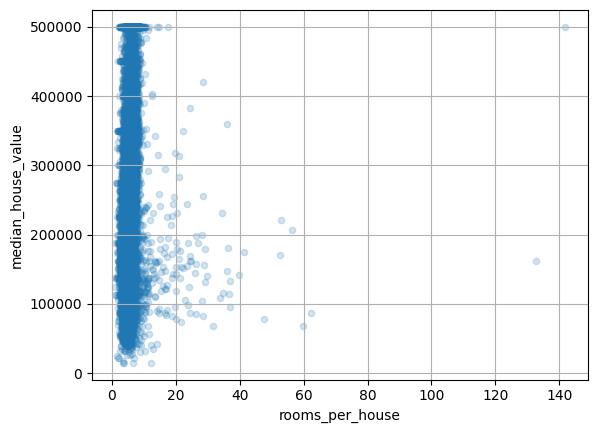

In [30]:
housing.plot(kind='scatter',
 x= "rooms_per_house",y="median_house_value",grid=True, alpha=0.2)

In [31]:
import seaborn as sns

<Axes: xlabel='rooms_per_house', ylabel='median_house_value'>

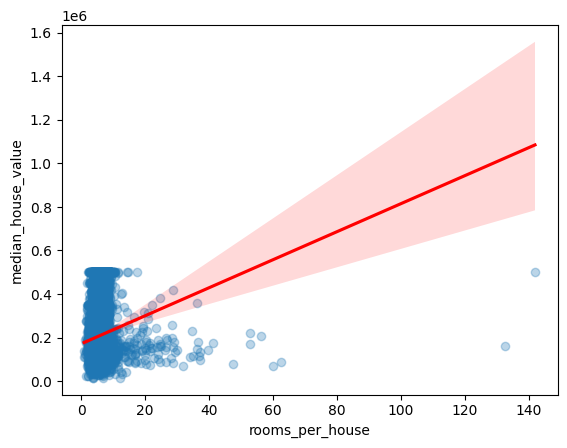

In [32]:
sns.regplot(
    y="median_house_value",
    x="rooms_per_house",
    data=housing,
    scatter_kws={"alpha":0.3},
    line_kws={"color":"red"}
)

<Axes: xlabel='bedrooms_per_room', ylabel='median_house_value'>

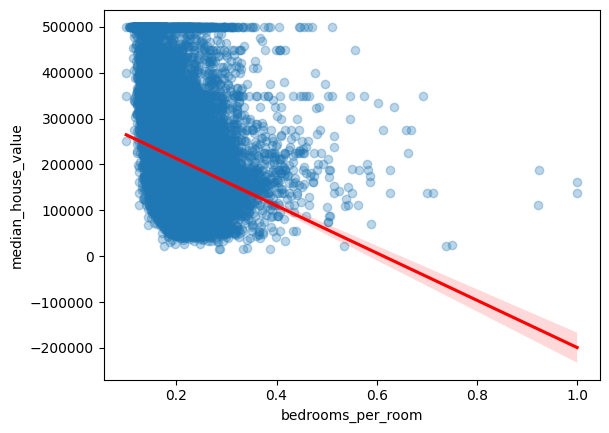

In [33]:
sns.regplot(
    data=housing,  # ✅ use the variable, not "housing"
    x="bedrooms_per_room",
    y="median_house_value",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "red"}
)


above modify attribute showing positive and neg strong correlation that is useful now our goal is to prepare our data before give to our model our data understanding part is over


In [34]:
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     16512 non-null  int64  
 1   longitude                 16512 non-null  float64
 2   latitude                  16512 non-null  float64
 3   housing_median_age        16512 non-null  float64
 4   total_rooms               16512 non-null  float64
 5   total_bedrooms            16344 non-null  float64
 6   population                16512 non-null  float64
 7   households                16512 non-null  float64
 8   median_income             16512 non-null  float64
 9   median_house_value        16512 non-null  float64
 10  ocean_proximity           16512 non-null  object 
 11  id                        16512 non-null  float64
 12  rooms_per_house           16512 non-null  float64
 13  bedrooms_per_room         16344 non-null  float64
 14  populat

total bedroom has 16344 not null entries but has 168 missing values

In [36]:
median = housing['total_bedrooms'].median()
print(median)

434.0


In [37]:
housing['total_bedrooms'].fillna(median,inplace=True)

/tmp/ipython-input-37-1536663952.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing['total_bedrooms'].fillna(median,inplace=True)


In [38]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     16512 non-null  int64  
 1   longitude                 16512 non-null  float64
 2   latitude                  16512 non-null  float64
 3   housing_median_age        16512 non-null  float64
 4   total_rooms               16512 non-null  float64
 5   total_bedrooms            16512 non-null  float64
 6   population                16512 non-null  float64
 7   households                16512 non-null  float64
 8   median_income             16512 non-null  float64
 9   median_house_value        16512 non-null  float64
 10  ocean_proximity           16512 non-null  object 
 11  id                        16512 non-null  float64
 12  rooms_per_house           16512 non-null  float64
 13  bedrooms_per_room         16344 non-null  float64
 14  populat

now its fill with median its very optimise way to do that because median not affect with outliers . there  are several other solution to do this that not recommended like drop only missing row by dropna
and delete entire column but both not recommended

**handling text value :-** ocean_proximity has text value we need to handle by encoding

In [39]:
housing_cat= housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [40]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder=OneHotEncoder(sparse_output=False,handle_unknown="ignore") #  without "ignore " it raise error when miss value
housing_cat_1hot=onehot_encoder.fit_transform(housing_cat)


here we have done one hot encoding it useful for production then get_dummy give by pandas
we avoid use ordinal encoding because its unordered categories . here we also ignore missing value

In [41]:
print(housing_cat_1hot)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [42]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

here we have the categories that we have transformed

In [43]:
housing_num = housing.select_dtypes(include=['float','int'])


In [44]:
print(housing_num.info())

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     16512 non-null  int64  
 1   longitude                 16512 non-null  float64
 2   latitude                  16512 non-null  float64
 3   housing_median_age        16512 non-null  float64
 4   total_rooms               16512 non-null  float64
 5   total_bedrooms            16512 non-null  float64
 6   population                16512 non-null  float64
 7   households                16512 non-null  float64
 8   median_income             16512 non-null  float64
 9   median_house_value        16512 non-null  float64
 10  id                        16512 non-null  float64
 11  rooms_per_house           16512 non-null  float64
 12  bedrooms_per_room         16344 non-null  float64
 13  population_per_household  16512 non-null  float64
dtypes: floa

In [45]:
from sklearn.preprocessing import StandardScaler
std_scaler=StandardScaler()
housing_scaled=std_scaler.fit_transform(housing_num)

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'rooms_per_house'}>],
       [<Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>, <Axes: >,
        <Axes: >]], dtype=object)

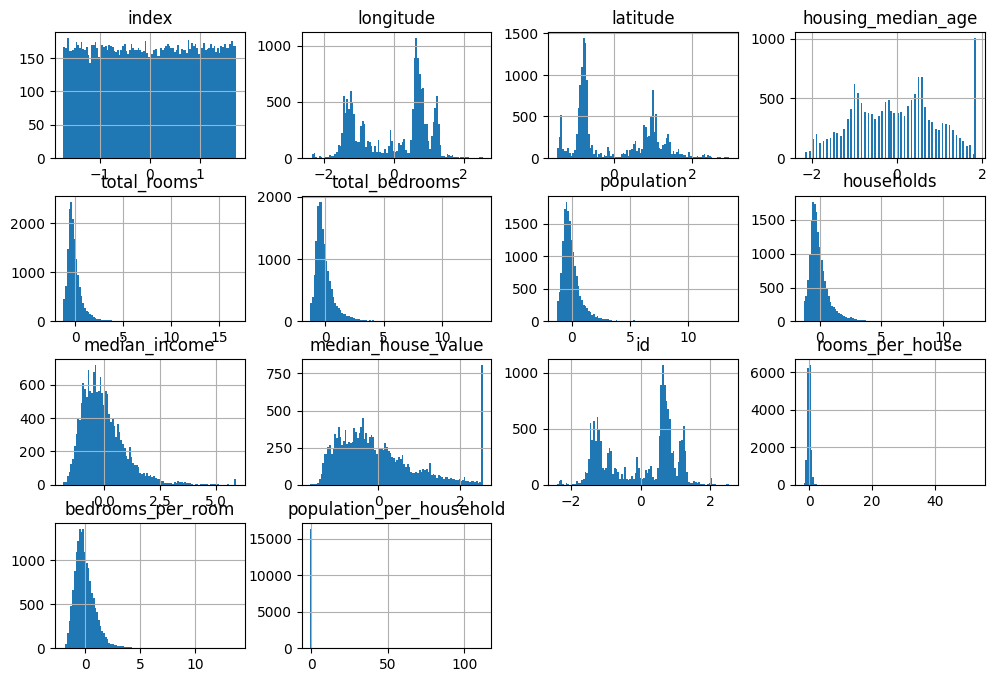

In [46]:
housing_scaled_df = pd.DataFrame(housing_scaled, columns=housing_num.columns)

housing_scaled_df.hist(bins=100, figsize=(12, 8))


above is scaled graph look at x axis

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'rooms_per_house'}>],
       [<Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>, <Axes: >,
        <Axes: >]], dtype=object)

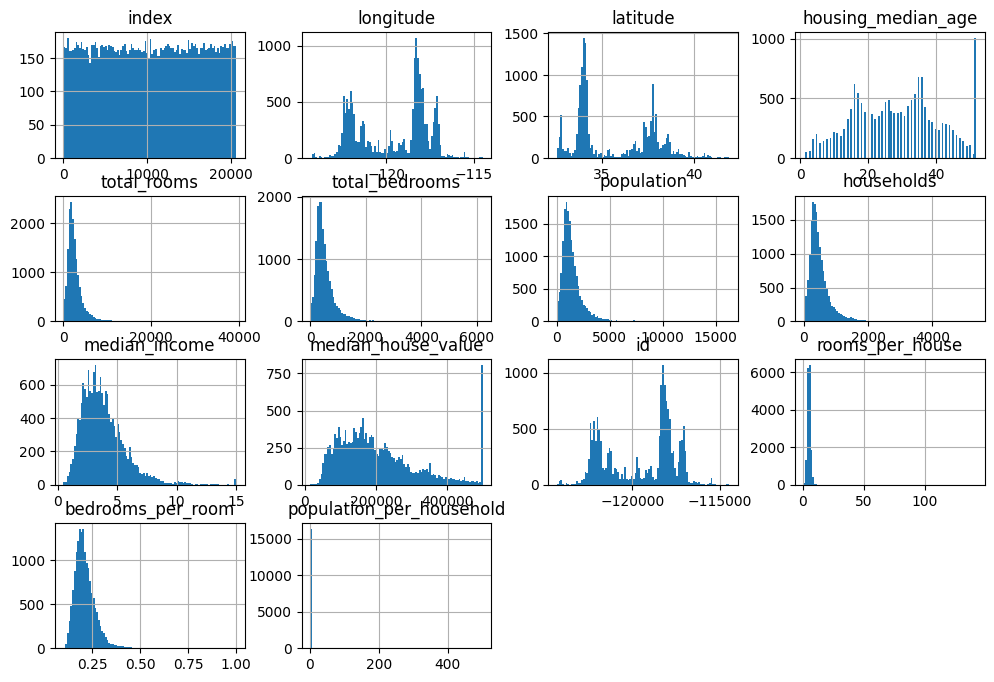

In [47]:
housing.hist(bins=100, figsize=(12, 8))

In [48]:
std_scaler=StandardScaler(with_mean=False)

housing_scaled_1hot=std_scaler.fit_transform(housing_cat_1hot)

In [49]:
housing_cat_pd= pd.DataFrame(housing_scaled_1hot,columns=onehot_encoder.categories_)

array([[<Axes: title={'center': "('<1H OCEAN',)"}>,
        <Axes: title={'center': "('INLAND',)"}>],
       [<Axes: title={'center': "('ISLAND',)"}>,
        <Axes: title={'center': "('NEAR BAY',)"}>],
       [<Axes: title={'center': "('NEAR OCEAN',)"}>, <Axes: >]],
      dtype=object)

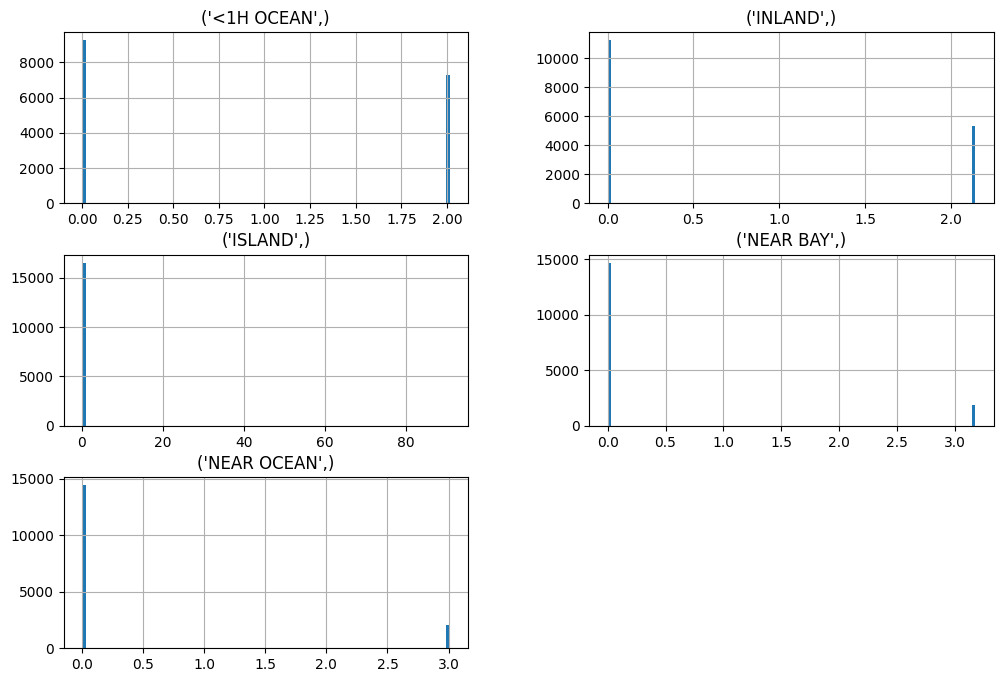

In [50]:
housing_cat_pd.hist(bins=100, figsize=(12, 8))

In [51]:
from sklearn.metrics.pairwise import rbf_kernel

age_sim_35 = rbf_kernel(housing_scaled_df[["housing_median_age"]], [[35]], gamma=0.03)
age_df = pd.DataFrame(age_sim_35, columns=["age_sim_35"])

array([[<Axes: title={'center': 'age_sim_35'}>]], dtype=object)

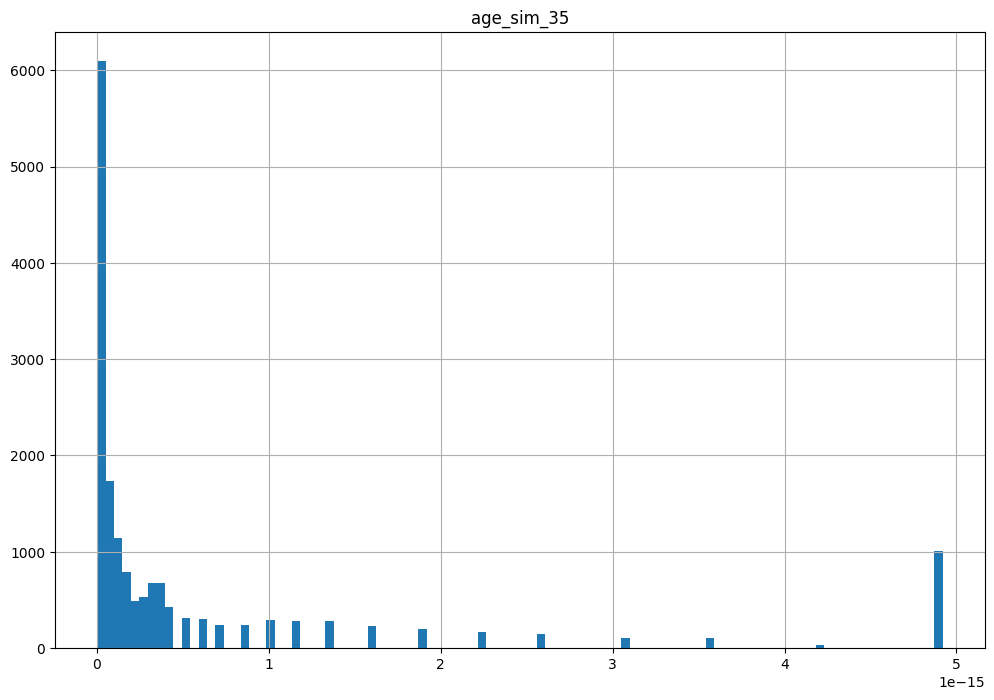

In [52]:
age_df.hist(bins=100, figsize=(12, 8))

In [53]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

# Example: transform multiple columns
cols_to_log = ["total_rooms", "total_bedrooms", "population", "households"]
housing_scaled_df[cols_to_log] = log_transformer.transform(housing_scaled_df[cols_to_log])



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:387: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'rooms_per_house'}>],
       [<Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>, <Axes: >,
        <Axes: >]], dtype=object)

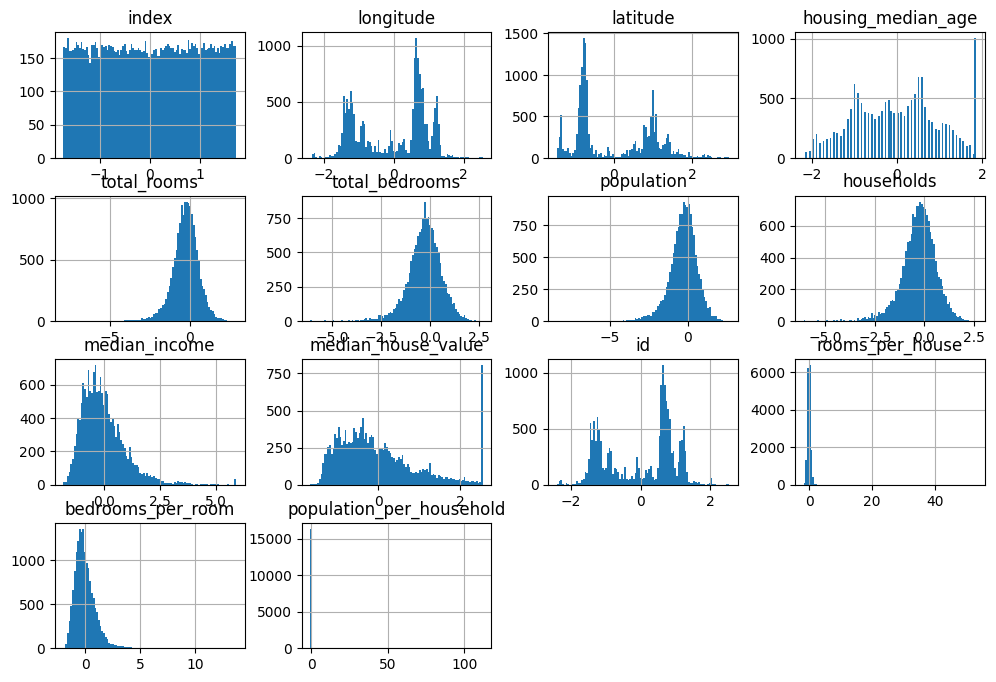

In [54]:

housing_scaled_df.hist(bins=100, figsize=(12, 8))

In [55]:
housing_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     16512 non-null  float64
 1   longitude                 16512 non-null  float64
 2   latitude                  16512 non-null  float64
 3   housing_median_age        16512 non-null  float64
 4   total_rooms               15967 non-null  float64
 5   total_bedrooms            15893 non-null  float64
 6   population                15749 non-null  float64
 7   households                15755 non-null  float64
 8   median_income             16512 non-null  float64
 9   median_house_value        16512 non-null  float64
 10  id                        16512 non-null  float64
 11  rooms_per_house           16512 non-null  float64
 12  bedrooms_per_room         16344 non-null  float64
 13  population_per_household  16512 non-null  float64
dtypes: flo

In [56]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
column=["total_rooms","total_bedrooms","population","households"]
housing_scaled_df[column] = imputer.fit_transform(housing_scaled_df[column])

In [57]:
housing_scaled_df[column] = log_transformer.transform(housing_scaled_df[column])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_function_transformer.py:387: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'rooms_per_house'}>],
       [<Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>, <Axes: >,
        <Axes: >]], dtype=object)

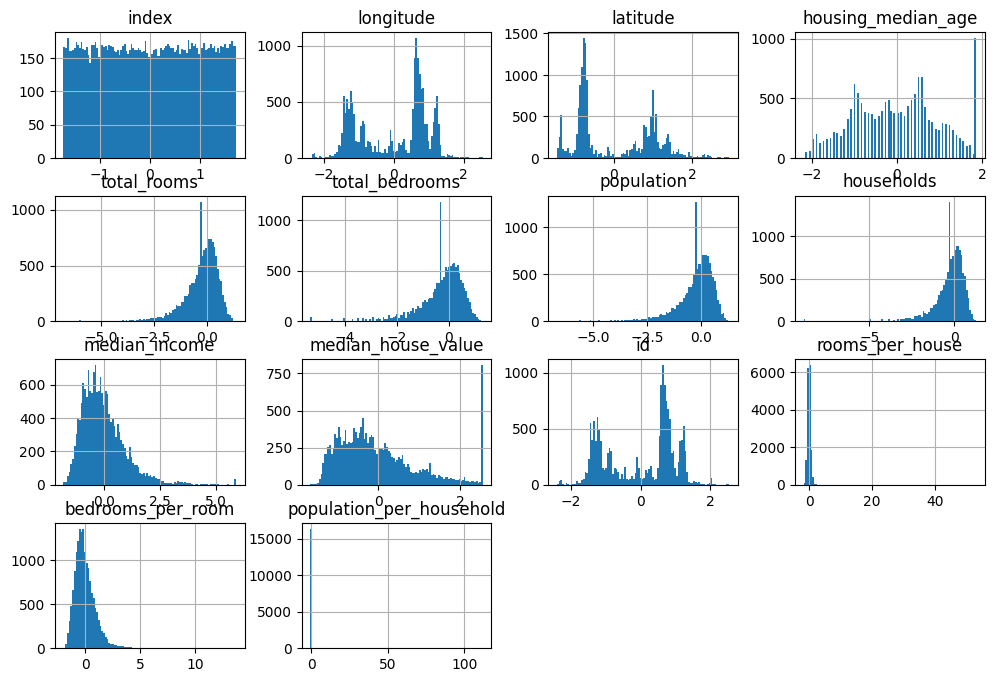

In [58]:
housing_scaled_df.hist(bins=100, figsize=(12, 8))

In [59]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

# Reference point: San Francisco coordinates
sf_coord = [[37.7749, -122.41]]

# Create the RBF kernel transformer
sf_transformer = FunctionTransformer(
    rbf_kernel,
    kw_args=dict(Y=sf_coord, gamma = 0.0005)
)

# Apply transformer to latitude and longitude
housing_scaled_df["sf_similarity"] = sf_transformer.transform(
    housing_scaled_df[["latitude", "longitude"]]
)


array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>],
       [<Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'rooms_per_house'}>],
       [<Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>,
        <Axes: title={'center': 'sf_similarity'}>, <Axes: >]],
      dtype=object)

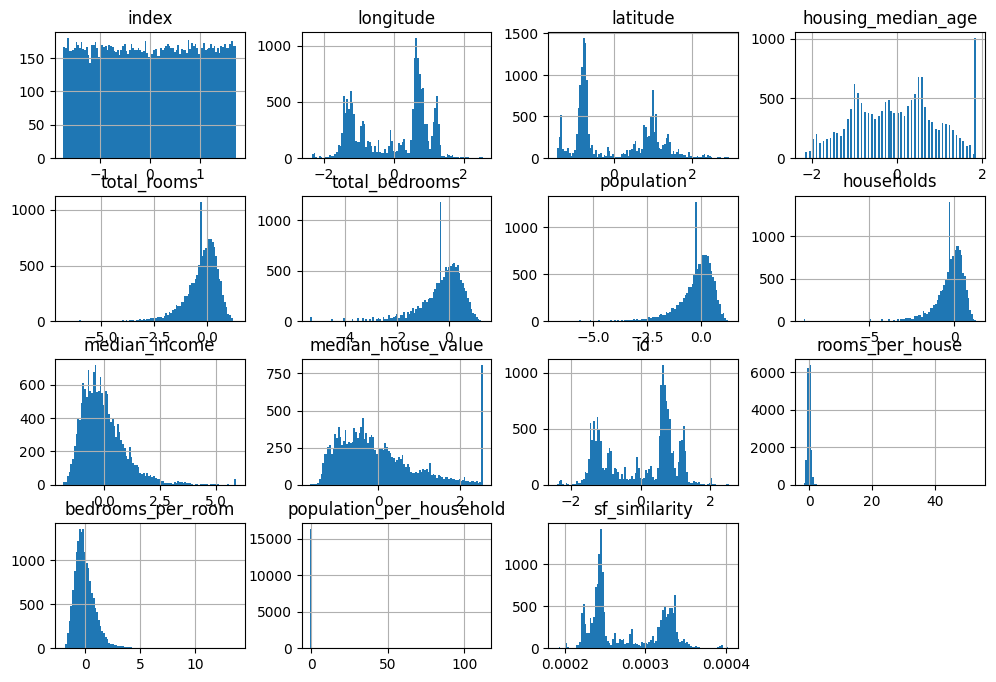

In [60]:
housing_scaled_df.hist(bins=100, figsize=(12, 8))

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)


In [62]:

housing_scaled_df.columns = housing_scaled_df.columns.astype(str)

numeric_cols = housing_scaled_df.select_dtypes(include=["float", "int"]).columns

housing_scaled_df[numeric_cols] = pipeline.fit_transform(housing_scaled_df[numeric_cols])


In [70]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, input_features=None):
        return [f"cluster_similarity_{i}" for i in range(self.n_clusters)]


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(transformer, feature_names_in):
    return [f"{feature_names_in[0]}_per_{feature_names_in[1]}"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler()
    )

# --- Pipelines ---
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),  # log(1 + x)
    StandardScaler()
)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

# --- Full preprocessing pipeline ---
preprocessing = ColumnTransformer(
    transformers=[
        ("bedrooms_ratio", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", ClusterSimilarity(n_clusters=18, gamma=1.0, random_state=42), ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline
)



In [72]:
housing_prepared=preprocessing.fit_transform(housing)

In [73]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__total_bedrooms_per_total_rooms',
       'rooms_per_house__total_rooms_per_households',
       'people_per_house__population_per_households',
       'log__total_bedrooms', 'log__total_rooms', 'log__population',
       'log__households', 'log__median_income',
       'geo__cluster_similarity_0', 'geo__cluster_similarity_1',
       'geo__cluster_similarity_2', 'geo__cluster_similarity_3',
       'geo__cluster_similarity_4', 'geo__cluster_similarity_5',
       'geo__cluster_similarity_6', 'geo__cluster_similarity_7',
       'geo__cluster_similarity_8', 'geo__cluster_similarity_9',
       'geo__cluster_similarity_10', 'geo__cluster_similarity_11',
       'geo__cluster_similarity_12', 'geo__cluster_similarity_13',
       'geo__cluster_similarity_14', 'geo__cluster_similarity_15',
       'geo__cluster_similarity_16', 'geo__cluster_similarity_17',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_pro